# Comparison of Turbidity from Seapoint and SeaBird Sensors

In this notebook we load and parse data from two Seapoint Turbidity Meters (TURBD) and two SeaBird Fluorometers (FLORT) that have been calibrated to measure turbidity with the backscatter (700 nm) channel. After evaluating the burst median on the FLORT datasets, we explore the relationship of TURBD turbidity to FLORT turbidity through timeseries, scatter plots, and linear regressions throughout AST3. Additional median filtering with a rolling window may be done to smooth over changes on time scales shorter than daily to weekly.

In [119]:
# Import libraries used in this notebook
from concurrent.futures import ThreadPoolExecutor
import requests
import os
import glob
import re
from datetime import date

from Parsers.parsers import TURBD, FLORT

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from bs4 import BeautifulSoup as bs
from urllib.parse import urljoin, urlparse
from sklearn.linear_model import LinearRegression

In [27]:
# Define functions for importing, downloading, or parsing data
os.makedirs("C:/Users/kylene.cooley/ast3_turbidity_data", exist_ok=True)
savepath = os.path.abspath("C:/Users/kylene.cooley/ast3_turbidity_data/")
def download_file(url, savepath=savepath):
    response = requests.get(url)
    if response.status_code == 200:
        filename = response.url.split("/")[-1]
    else:
        filename = url.split("/")[-1]
    with open("/".join([savepath, filename]), mode="wb") as file:
        file.write(response.content)
    print(f"Downloaded file {filename}")
    
# Define functions to download multiple files from a URL in parallel
# Adapted from online tutorials: [insert links here]
def is_valid(url):
    """ Checks whether URL is valid
    """
    parsed = urlparse(url)
    return bool(parsed.netloc) and bool(parsed.scheme)

def get_file_urls(url: str, instr: str, start_date: int, end_date: int):
    """ Returns URLS to any .log files on the page.
    """
    soup = bs(requests.get(url).content, "html.parser")
    urls = []
    for log in tqdm(soup.find_all("a", string=re.compile(instr+".log\Z")), "Finding logger files"):
        log_url = log.attrs.get("href")
        if int(log_url[:8]) >= start_date and int(log_url[:8]) <= end_date:
            log_url = urljoin(url, log_url)
            if is_valid(log_url):
                urls.append(log_url)
        else:
            continue

    return urls

### Parse TURBD raw recovered host data

In [2]:
# Create response object for HTML request of NSIF TURBD data
url = "https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/turbd"
response = requests.get(url, stream=True)
response.url

'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/turbd/'

In [6]:
# Download TURBD recovered host data to local directory in savepath variable
with open("{}}/{filename}".format(savepath, filename=response.url.split('/')[-1]), mode="wb") as file:
    file.write(response.content)

In [2]:
# Create list of downloaded data files
files = glob.glob("data/ast3_turbidity_data/*.turbd.log")
files

['data/ast3_turbidity_data/20230109.turbd.log']

In [8]:
# Load TURBD data with TURBD object from Parsers.parsers module
turbd = TURBD()
turbd.load_turbd(files)
data = turbd.DATA

Parsing 20230109.turbd.log


In [9]:
# Check dataframe contents
data

,LGR_TIMESTAMP,TIMESTAMP,TURBIDITY
0,2023-01-09 00:00:05.674,2023-01-09 00:00:03.500,6.1616
1,2023-01-09 00:00:06.175,2023-01-09 00:00:04.000,6.1662
2,2023-01-09 00:00:06.674,2023-01-09 00:00:04.500,6.1648
3,2023-01-09 00:00:07.174,2023-01-09 00:00:05.000,6.1640
4,2023-01-09 00:00:07.675,2023-01-09 00:00:05.500,6.1633
...,...,...,...
5664,2023-01-09 23:31:02.230,2023-01-09 23:31:00.000,6.2734
5665,2023-01-09 23:31:02.733,2023-01-09 23:31:00.500,6.2758
5666,2023-01-09 23:31:03.231,2023-01-09 23:31:01.000,6.2758
5667,2023-01-09 23:31:03.730,2023-01-09 23:31:01.500,6.2749


### Plot recovered instrument data

The recovered instrument data recorded during AST3 from each of the Seapoint turbidity meters (one on the NSIF, one on the MFN) are available from the raw data repo as an excel spreadsheet in a workbook. For the following section, I had the recovered instrument files saved in the local savefile path so that I could load the data spreadsheet with Pandas.

#### TURBD sensor on the NSIF

In [86]:
# Load recovered instrument data from the Seapoint turbidity sensor on the NSIF
nsif_turbd = pd.read_excel(os.path.abspath('C:/Users/kylene.cooley/ast3_turbidity_data/TURBD_17570_RBR_LGR_209675_20231031_2048_Data_Export.xlsx'),
                        sheet_name='Data', header=1, index_col=0, skiprows=0, parse_dates=True, date_format="np.datetime64")
# nsif_turbd

c:\Users\kylene.cooley\AppData\Local\anaconda3\envs\ast3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


#### TURBD sensor on the MFN

In [87]:
# Load recovered instrument data from the Seapoint turbidity sensor on the MFN
mfn_turbd = pd.read_excel('C:/Users/kylene.cooley/ast3_turbidity_data/TURBD_17576_RBR_LGR_209676_20231102_1823.xlsx',
                        sheet_name='Data', header=1, index_col=0, skiprows=0, parse_dates=True, date_format="np.datetime64")
# mfn_turbd

c:\Users\kylene.cooley\AppData\Local\anaconda3\envs\ast3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


#### Convert pandas series to xarray Data Arrays and plot turbidity

In [88]:
# Create xarray data arrays from pandas data frames with one dimension
# We with henceforth refer to NSIF turbidity as turbd1 to match flort1 used later, 
# and similarly turbd2 to match flort2 (although the TURBD sensor was separate from DCL36)
turbd1 = xr.DataArray(nsif_turbd["Turbidity"], dims="Time")
turbd2 = xr.DataArray(mfn_turbd["Turbidity"], dims="Time")

In [89]:
# Assign datetime64 copy of "Time" (object dtype) as coordinate corresponding to "Time" dimension
turbd1 = turbd1.assign_coords({"Time": turbd1["Time"].astype(np.datetime64).values})
turbd2 = turbd2.assign_coords({"Time": turbd2["Time"].astype(np.datetime64).values})

C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_208236\1601262309.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  turbd1 = turbd1.assign_coords({"Time": turbd1["Time"].astype(np.datetime64).values})
C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_208236\1601262309.py:3: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or 

In [173]:
# Checking time delta for turbidity from Seapoint turbidity meters
print(turbd1["Time"][0:2].values)
print(turbd2["Time"][60:62].values)

['2023-02-17T15:00:01.000000000' '2023-02-17T15:30:01.000000000']
['2023-02-23T23:00:01.000000000' '2023-02-23T23:30:01.000000000']


The turbidity meters on both the NSIF and the MFN sampled once every 30 minutes.

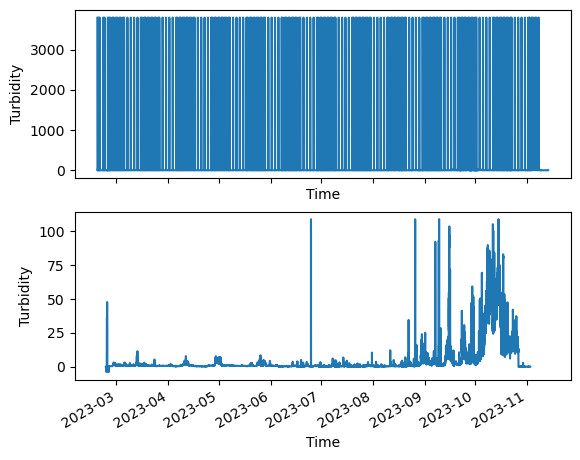

In [20]:
# Plot unfiltered turbidity timeseries from Seapoint sensors on NSIF and MFN
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
turbd1.plot.line(ax=axs[0])
turbd2.plot.line(ax=axs[1])

The turbidity from the NSIF Seapoint Turbidity sensor has data values greater than the expected range of the sensor, so we will apply a simple mask for values greater than 25 NTU (expected 0-25 NTU) to resolve the majority of the measured values in the time series. The expected range for the sensor on the NSIF referenced here is pulled from the At-Sea Test 3 Plan document. The Seapoint Turbidity sensor data sheet indicates that the maximum FTU (used in data sheet) value is only 4000 when gain is set to 1x. Gain should have been set to 100x for maximum readings of 25 FTU. The Deployment Info screenshot on the raw data repo shows that the sensor range was set to 25 NTU.

In [90]:
# Mask turbidity values from NSIF Seapoint over 25 NTU
turbd1 = turbd1.where(turbd1 <= 25)

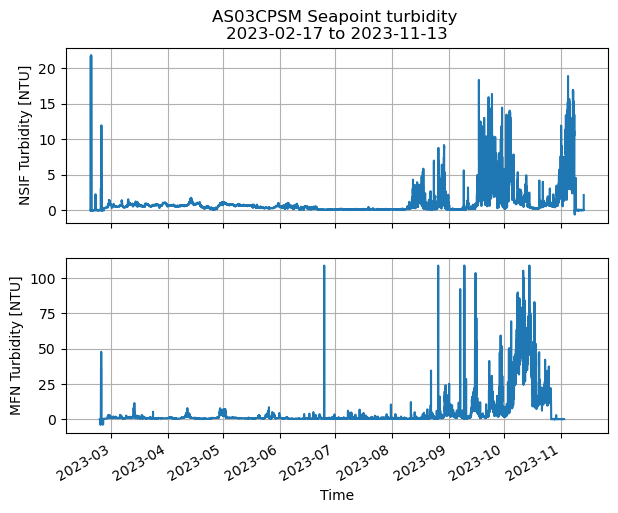

In [23]:
# Plot masked NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[7, 5])
turbd1.plot.line(ax=axs[0])
axs[0].grid()
axs[0].set_ylabel('NSIF Turbidity [NTU]')
axs[0].set_xlabel('')
turbd2.plot.line(ax=axs[1])
axs[1].grid()
axs[1].set_ylabel('MFN Turbidity [NTU]')
axs[0].set_title(f'AS03CPSM Seapoint turbidity \n{turbd1["Time"][0].values:.10} to {turbd1["Time"][-1].values:.10}')
plt.savefig('figures/AS03CPSM_TURBD_full_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

#### Plot Seapoint turbidity in July with smaller turbidity range

In [26]:
# Index Seapoint turbidity measured in July 2023
turbd1_jul = turbd1.sel(Time="July 2023")
turbd2_jul = turbd2.sel(Time="July 2023")

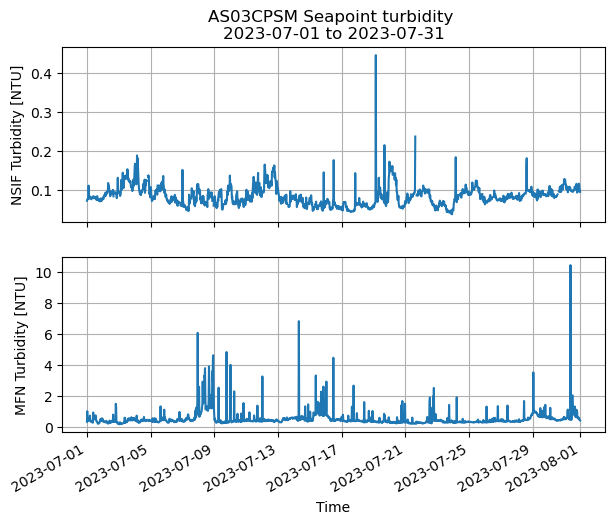

In [25]:
# Plot masked NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[7, 5])
turbd1_jul.plot.line(ax=axs[0])
axs[0].grid()
axs[0].set_ylabel('NSIF Turbidity [NTU]')
axs[0].set_xlabel('')
turbd2_jul.plot.line(ax=axs[1])
axs[1].grid()
axs[1].set_ylabel('MFN Turbidity [NTU]')
axs[0].set_title(f'AS03CPSM Seapoint turbidity \n{turbd1_Jul["Time"][0].values:.10} to {turbd1_Jul["Time"][-1].values:.10}')
plt.savefig('figures/AS03CPSM_TURBD_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

#### Apply a median smoothing filter to Seapoint turbidity

In [34]:
# Use rolling window object for a 6-hour median smoothing filter
turbd1median_jul = turbd1_jul.rolling(Time=12, center=True).median()
turbd2median_jul = turbd2_jul.rolling(Time=12, center=True).median()

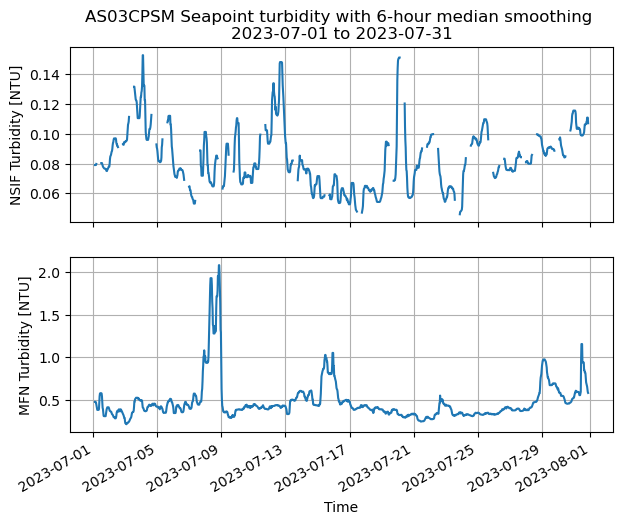

In [36]:
# Plot median-smoothed NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[7, 5])
turbd1median_jul.plot.line(ax=axs[0])
axs[0].grid()
axs[0].set_ylabel('NSIF Turbidity [NTU]')
axs[0].set_xlabel('')
turbd2median_jul.plot.line(ax=axs[1])
axs[1].grid()
axs[1].set_ylabel('MFN Turbidity [NTU]')
axs[0].set_title(f'AS03CPSM Seapoint turbidity with 6-hour median smoothing \n{turbd1median_jul["Time"][0].values:.10} to {turbd1median_jul["Time"][-1].values:.10}')
plt.savefig('figures/AS03CPSM_TURBD_6hrmedian_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

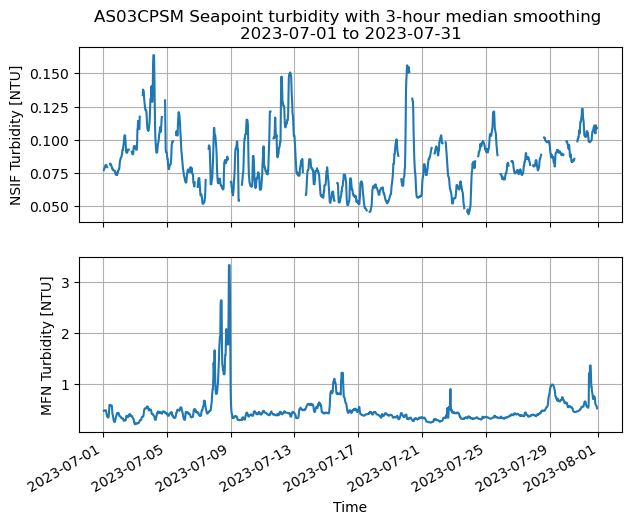

In [37]:
# Try filtering with a 3 hour median filter for better coverage
turbd1median_jul = turbd1_jul.rolling(Time=6, center=True).median()
turbd2median_jul = turbd2_jul.rolling(Time=6, center=True).median()

# Plot median-smoothed NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[7, 5])
turbd1median_jul.plot.line(ax=axs[0])
axs[0].grid()
axs[0].set_ylabel('NSIF Turbidity [NTU]')
axs[0].set_xlabel('')
turbd2median_jul.plot.line(ax=axs[1])
axs[1].grid()
axs[1].set_ylabel('MFN Turbidity [NTU]')
axs[0].set_title(f'AS03CPSM Seapoint turbidity with 3-hour median smoothing \n{turbd1median_jul["Time"][0].values:.10} to {turbd2median_jul["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_turbidity_3hrmedian_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

### Compare TURBD with turbidity from FLORT sensors

#### Download flort1 recovered host data

In [6]:
# Use url for flort1 recovered host data files on the Raw Data Repo
url = "https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/"

In [16]:
# Set up file URL request with start and end dates of AST3 deployment from quick look cruise reports
files = get_file_urls(url, instr="flort1", start_date=20230224, end_date=20231026)
files

Finding logger files: 100%|██████████| 308/308 [00:00<00:00, 25572.49it/s]


['https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230224.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230225.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230226.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230227.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230228.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230301.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230302.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230303.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230304.flort1.log',
 

In [17]:
with ThreadPoolExecutor() as executor:
    executor.map(download_file, files)

Downloaded file 20230227.flort1.log
Downloaded file 20230319.flort1.log
Downloaded file 20230314.flort1.log
Downloaded file 20230304.flort1.log
Downloaded file 20230309.flort1.log
Downloaded file 20230226.flort1.log
Downloaded file 20230305.flort1.log
Downloaded file 20230303.flort1.log
Downloaded file 20230318.flort1.log
Downloaded file 20230228.flort1.log
Downloaded file 20230308.flort1.log
Downloaded file 20230313.flort1.log
Downloaded file 20230310.flort1.log
Downloaded file 20230315.flort1.log
Downloaded file 20230320.flort1.log
Downloaded file 20230321.flort1.log
Downloaded file 20230323.flort1.log
Downloaded file 20230322.flort1.log
Downloaded file 20230324.flort1.log
Downloaded file 20230224.flort1.log
Downloaded file 20230312.flort1.log
Downloaded file 20230325.flort1.log
Downloaded file 20230327.flort1.log
Downloaded file 20230306.flort1.log
Downloaded file 20230301.flort1.log
Downloaded file 20230328.flort1.log
Downloaded file 20230311.flort1.log
Downloaded file 20230326.flo

#### Load flort1 data from logger files 

In [2]:
# Use FLORT class imported from Parsers.parsers to load flort1 data from downloaded logger files
files = glob.glob("C:/Users/kylene.cooley/ast3_turbidity_data/*.flort1.log")
flort1 = FLORT()
flort1.load_flort(files)

# Check how data looks initially after loading FLORT recovered host data
flort_data = flort1.DATA
flort_data

Parsing ast3_turbidity_data\20230222.flort1.log
Parsing ast3_turbidity_data\20230223.flort1.log
Parsing ast3_turbidity_data\20230224.flort1.log
Parsing ast3_turbidity_data\20230225.flort1.log
Parsing ast3_turbidity_data\20230226.flort1.log
Parsing ast3_turbidity_data\20230227.flort1.log
Parsing ast3_turbidity_data\20230228.flort1.log
Parsing ast3_turbidity_data\20230301.flort1.log
Parsing ast3_turbidity_data\20230302.flort1.log
Parsing ast3_turbidity_data\20230303.flort1.log
Parsing ast3_turbidity_data\20230304.flort1.log
Parsing ast3_turbidity_data\20230305.flort1.log
Parsing ast3_turbidity_data\20230306.flort1.log
Parsing ast3_turbidity_data\20230307.flort1.log
Parsing ast3_turbidity_data\20230308.flort1.log
Parsing ast3_turbidity_data\20230309.flort1.log
Parsing ast3_turbidity_data\20230310.flort1.log
Parsing ast3_turbidity_data\20230311.flort1.log
Parsing ast3_turbidity_data\20230312.flort1.log
Parsing ast3_turbidity_data\20230313.flort1.log
Parsing ast3_turbidity_data\20230314.flo

c:\Users\kylene.cooley\Documents\GitHub\AST3\Parsers\parsers.py:571: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.DATA = flort_data.astype(self.DATA_TYPE)


In [4]:
# Convert backscatter to turbidity with FLORT bound method
# Scale factor and dark counts are from Secondary Characterizaton Sheet for FLORT-D SN1005
tu_flort1 = flort1.flort2turb(scale_factor=0.0008, dark_counts=49)
tu_flort1

In [11]:
tu_flort1 = tu_flort1.rename({"TIMESTAMP": "time"}, axis=1)
tu_flort1

,LGR_TIMESTAMP,time,CH1,700NM_COUNTS,CH2,695NM_COUNTS,CH3,460NM_COUNTS,THERM_COUNTS,backscatter_turb
0,2023-02-22 00:00:15.429,2023-02-21 23:59:36,700,4130,695,1253,460,4130,543,3.2648
1,2023-02-22 00:00:16.563,2023-02-21 23:59:37,700,4130,695,1253,460,4130,543,3.2648
2,2023-02-22 00:00:17.697,2023-02-21 23:59:38,700,4130,695,1251,460,4130,543,3.2648
3,2023-02-22 00:00:18.831,2023-02-21 23:59:39,700,4130,695,1254,460,4130,542,3.2648
4,2023-02-22 00:00:19.964,2023-02-21 23:59:41,700,4130,695,1251,460,4130,543,3.2648
...,...,...,...,...,...,...,...,...,...,...
804,2023-10-26 09:00:56.910,2023-10-26 08:56:35,700,519,695,158,460,59,542,0.3760
805,2023-10-26 09:00:58.025,2023-10-26 08:56:36,700,361,695,150,460,61,542,0.2496
806,2023-10-26 09:00:59.154,2023-10-26 08:56:37,700,392,695,140,460,61,542,0.2744
807,2023-10-26 09:01:00.284,2023-10-26 08:56:39,700,619,695,136,460,60,542,0.4560


In [12]:
# Convert Data Frame to Xarray Dataset
flort1_ntu = xr.Dataset.from_dataframe(tu_flort1.set_index("time"))
flort1_ntu

<xarray.Dataset>
Dimensions:           (time: 502579)
Coordinates:
  * time              (time) datetime64[ns] 2023-02-21T23:59:36 ... 2023-10-2...
Data variables:
    LGR_TIMESTAMP     (time) datetime64[ns] 2023-02-22T00:00:15.429000 ... 20...
    CH1               (time) object '700' '700' '700' ... '700' '700' '700'
    700NM_COUNTS      (time) int32 4130 4130 4130 4130 4130 ... 361 392 619 391
    CH2               (time) object '695' '695' '695' ... '695' '695' '695'
    695NM_COUNTS      (time) int32 1253 1253 1251 1254 1251 ... 150 140 136 137
    CH3               (time) object '460' '460' '460' ... '460' '460' '460'
    460NM_COUNTS      (time) int32 4130 4130 4130 4130 4130 ... 59 61 61 60 60
    THERM_COUNTS      (time) int32 543 543 543 542 543 ... 542 542 542 542 542
    backscatter_turb  (time) float64 3.265 3.265 3.265 ... 0.2744 0.456 0.2736

In [15]:
# Save Dataset to netCDF
savepath = os.path.abspath("C:/Users/kylene.cooley/ast3_turbidity_data/")
flort1_ntu.to_netcdf("/".join([savepath, "as03cpsm_dcl16_flort1.nc"]), mode="w")

#### Compare turbidity from flort1 and Seapoint turbidity on NSIF 

In [91]:
# Import flort1 data from locally saved dataset with turbidity variable
flort1 = xr.load_dataset("C:/Users/kylene.cooley/ast3_turbidity_data/as03cpsm_dcl16_flort1.nc")
flort1

<xarray.Dataset>
Dimensions:           (time: 502579)
Coordinates:
  * time              (time) datetime64[ns] 2023-02-21T23:59:36 ... 2023-10-2...
Data variables:
    LGR_TIMESTAMP     (time) datetime64[ns] 2023-02-22T00:00:15.429000 ... 20...
    CH1               (time) object '700' '700' '700' ... '700' '700' '700'
    700NM_COUNTS      (time) int32 4130 4130 4130 4130 4130 ... 361 392 619 391
    CH2               (time) object '695' '695' '695' ... '695' '695' '695'
    695NM_COUNTS      (time) int32 1253 1253 1251 1254 1251 ... 150 140 136 137
    CH3               (time) object '460' '460' '460' ... '460' '460' '460'
    460NM_COUNTS      (time) int32 4130 4130 4130 4130 4130 ... 59 61 61 60 60
    THERM_COUNTS      (time) int32 543 543 543 542 543 ... 542 542 542 542 542
    backscatter_turb  (time) float64 3.265 3.265 3.265 ... 0.2744 0.456 0.2736

In [63]:
# Check several timestamp values to decide on origin for resample
flort1["time"][0:60]

<xarray.DataArray 'time' (time: 60)>
array(['2023-02-21T23:59:36.000000000', '2023-02-21T23:59:37.000000000',
       '2023-02-21T23:59:38.000000000', '2023-02-21T23:59:39.000000000',
       '2023-02-21T23:59:41.000000000', '2023-02-21T23:59:42.000000000',
       '2023-02-21T23:59:43.000000000', '2023-02-21T23:59:44.000000000',
       '2023-02-21T23:59:45.000000000', '2023-02-21T23:59:46.000000000',
       '2023-02-21T23:59:47.000000000', '2023-02-21T23:59:48.000000000',
       '2023-02-21T23:59:50.000000000', '2023-02-21T23:59:51.000000000',
       '2023-02-21T23:59:52.000000000', '2023-02-21T23:59:53.000000000',
       '2023-02-21T23:59:54.000000000', '2023-02-21T23:59:55.000000000',
       '2023-02-21T23:59:56.000000000', '2023-02-21T23:59:58.000000000',
       '2023-02-21T23:59:59.000000000', '2023-02-22T00:00:00.000000000',
       '2023-02-22T00:00:01.000000000', '2023-02-22T00:00:02.000000000',
       '2023-02-22T00:00:03.000000000', '2023-02-22T00:00:04.000000000',
       '2023-02-22T00:00:05.000000000', '2023-02-22T00:00:07.000000000',
       '2023-02-22T00:00:08.000000000', '2023-02-22T00:00:09.000000000',
       '2023-02-22T00:00:10.000000000', '2023-02-22T00:00:11.000000000',
       '2023-02-22T00:00:12.000000000', '2023-02-22T00:00:13.000000000',
       '2023-02-22T00:00:15.000000000', '2023-02-22T00:00:16.000000000',
       '2023-02-22T00:00:17.000000000', '2023-02-22T00:00:18.000000000',
       '2023-02-22T00:00:19.000000000', '2023-02-22T00:00:20.000000000',
       '2023-02-22T00:00:21.000000000', '2023-02-22T00:00:22.000000000',
       '2023-02-22T00:29:35.000000000', '2023-02-22T00:29:37.000000000',
       '2023-02-22T00:29:38.000000000', '2023-02-22T00:29:39.000000000',
       '2023-02-22T00:29:40.000000000', '2023-02-22T00:29:41.000000000',
       '2023-02-22T00:29:42.000000000', '2023-02-22T00:29:43.000000000',
       '2023-02-22T00:29:45.000000000', '2023-02-22T00:29:46.000000000',
       '2023-02-22T00:29:47.000000000', '2023-02-22T00:29:48.000000000',
       '2023-02-22T00:29:49.000000000', '2023-02-22T00:29:50.000000000',
       '2023-02-22T00:29:51.000000000', '2023-02-22T00:29:52.000000000',
       '2023-02-22T00:29:54.000000000', '2023-02-22T00:29:55.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2023-02-21T23:59:36 ... 2023-02-22T00:29:55

In [92]:
# Evaluate median of each 1-min burst from FLORT sensor turbidity
flort1_ntu = flort1["backscatter_turb"]
flort1_resample = flort1_ntu.resample(time="30min", origin="start").median()
flort1_resample

<xarray.DataArray 'backscatter_turb' (time: 11826)>
array([3.2648, 3.2648, 3.2648, ..., 0.2064, 0.2312, 0.2704])
Coordinates:
  * time     (time) datetime64[ns] 2023-02-21T23:59:36 ... 2023-10-26T08:29:36

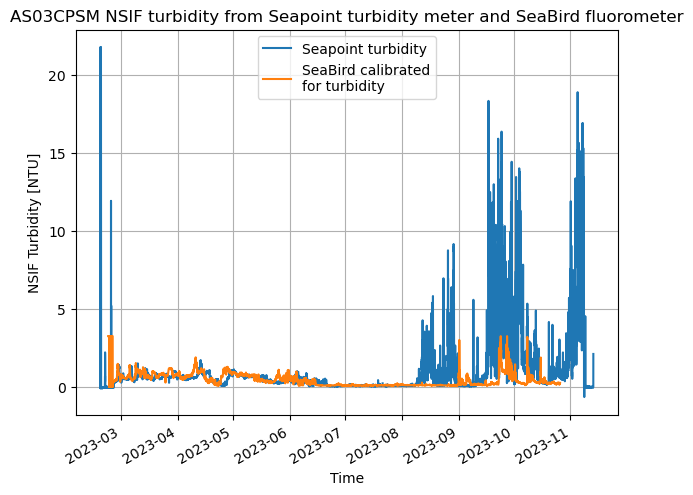

In [72]:
# Plot masked NSIF Seapoint turbidity (not smoothed) with turbidity from flort1 backscatter
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd1.plot.line(ax=axs, label="Seapoint turbidity")
flort1_resample.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity from Seapoint turbidity meter and SeaBird fluorometer')
plt.savefig('figures/AS03CPSM_TURBD1_FLORT1_full_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [78]:
# Recreate plot for July 2023 with NSIF data from both sensors
# Select Seapoint turbidity measured in July 2023
turbd1_jul = turbd1.sel(Time="July 2023")
flort1_jul = flort1_resample.sel(time="July 2023")

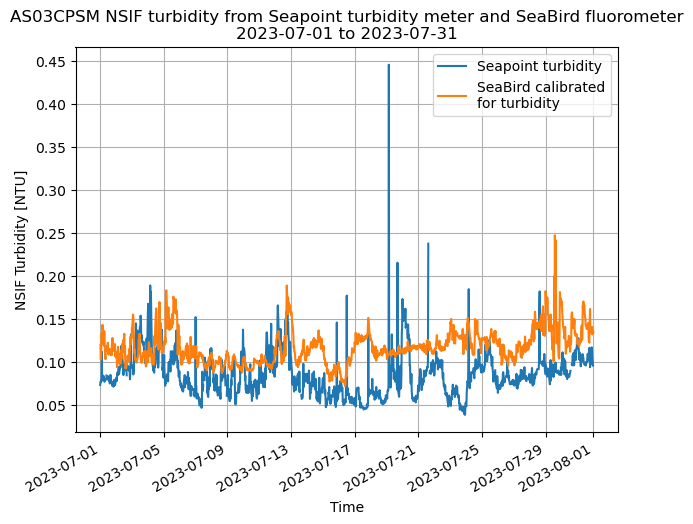

In [79]:
# Plot masked NSIF turbidity from Seapoint meter and FLORT-derived turbidity (burst median)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd1_jul.plot.line(ax=axs, label="Seapoint turbidity")
flort1_jul.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity from Seapoint turbidity meter and SeaBird fluorometer\n{turbd1_jul["Time"][0].values:.10} to {turbd1_jul["Time"][-1].values:.10}')
plt.savefig('figures/AS03CPSM_TURBD1_FLORT1_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [80]:
# Create time series variables for March 2023
turbd1_mar = turbd1.sel(Time="March 2023")
flort1_mar = flort1_resample.sel(time="March 2023")

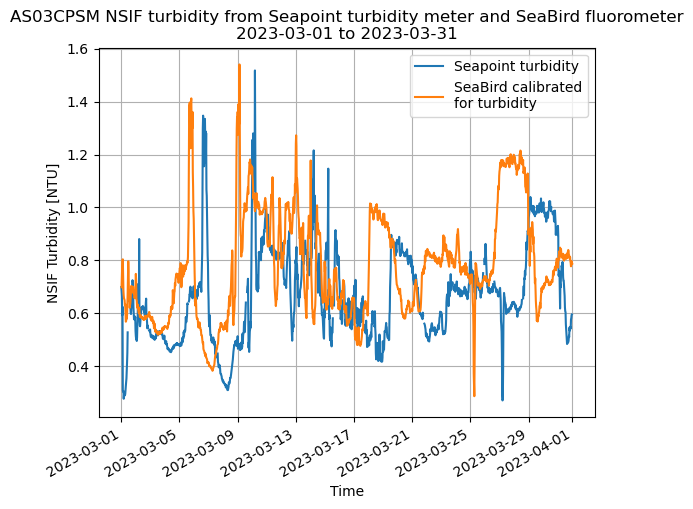

In [81]:
# Plot close-up of March 2023 with both TURBD1 and FLORT1 (burst median)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True)
turbd1_mar.plot.line(ax=axs, label="Seapoint turbidity")
flort1_mar.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity from Seapoint turbidity meter and SeaBird fluorometer\n{turbd1_mar["Time"][0].values:.10} to {turbd1_mar["Time"][-1].values:.10}')
plt.savefig('figures/AS03CPSM_TURBD1_FLORT1_Mar2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [83]:
# Create time series variables for May 2023
turbd1_may = turbd1.sel(Time="May 2023")
flort1_may = flort1_resample.sel(time="May 2023")

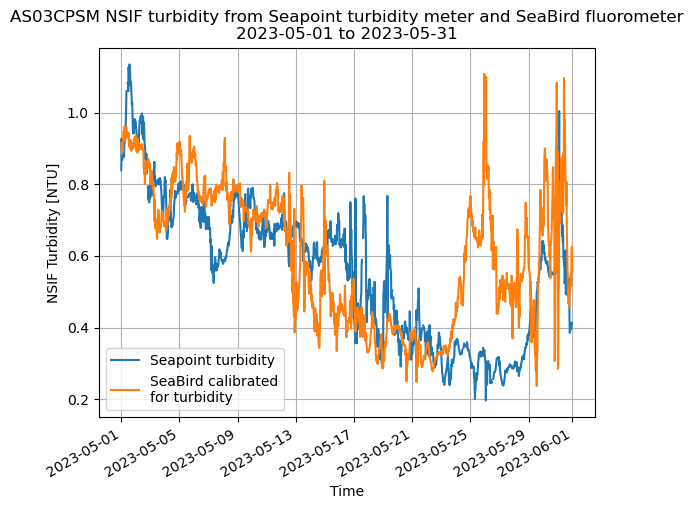

In [84]:
# Plot close-up of March 2023 with both TURBD1 and FLORT1 (burst median)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True)
turbd1_may.plot.line(ax=axs, label="Seapoint turbidity")
flort1_may.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity from Seapoint turbidity meter and SeaBird fluorometer\n{turbd1_may["Time"][0].values:.10} to {turbd1_may["Time"][-1].values:.10}')
plt.savefig('figures/AS03CPSM_TURBD1_FLORT1_May2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

#### Use 6-hr rolling median filter to smooth both signals and resolve daily variability

In [85]:
# Remake full timeseries comparison after applying median smoothing to both timeseries
turbd1_6hr = turbd1.rolling(Time=12, center=True).median()
flort1_6hr = flort1_resample.rolling(time=12, center=True).median()

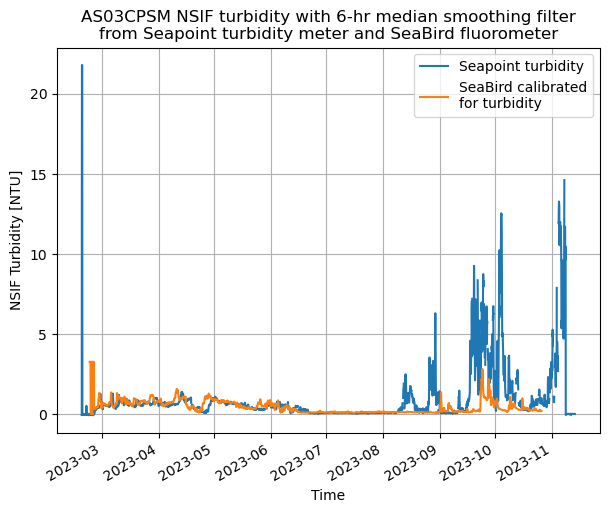

In [86]:
# Plot masked NSIF Seapoint turbidity (not smoothed) with turbidity from flort1 backscatter
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd1_6hr.plot.line(ax=axs, label="Seapoint turbidity")
flort1_6hr.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity with 6-hr median smoothing filter\nfrom Seapoint turbidity meter and SeaBird fluorometer')
# plt.savefig('figures/AS03CPSM_TURBD1_FLORT1_full_6hrmedian_{today}.png'.format(today=date.today().strftime('%Y%m%d'))) # not saving just yet
plt.show()

In [87]:
# Remake July 2023 plot after applying median smoothing to both timeseries
turbd1_jul = turbd1_6hr.sel(Time="July 2023")
flort1_jul = flort1_6hr.sel(time="July 2023")

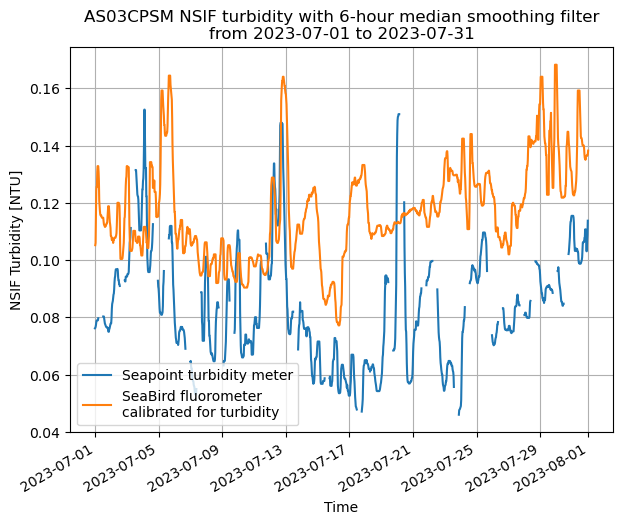

In [88]:
# Plot masked NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd1_jul.plot.line(ax=axs, label="Seapoint turbidity meter")
flort1_jul.plot.line(ax=axs, label="SeaBird fluorometer\ncalibrated for turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity with 6-hour median smoothing filter\nfrom {turbd1_jul["Time"][0].values:.10} to {turbd1_jul["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD1_FLORT1_Jul2023_6hrmedian_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [89]:
# Remake May 2023 plot after applying median smoothing to both timeseries
turbd1_may = turbd1_6hr.sel(Time="May 2023")
flort1_may = flort1_6hr.sel(time="May 2023")

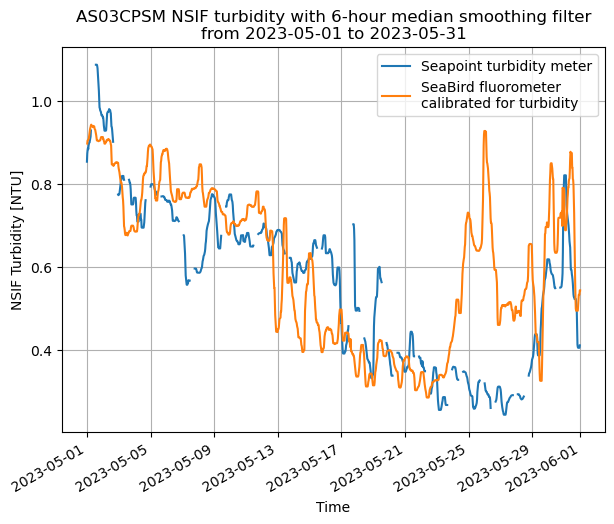

In [90]:
# Plot masked NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd1_may.plot.line(ax=axs, label="Seapoint turbidity meter")
flort1_may.plot.line(ax=axs, label="SeaBird fluorometer\ncalibrated for turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity with 6-hour median smoothing filter\nfrom {turbd1_may["Time"][0].values:.10} to {turbd1_may["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD1_FLORT1_May2023_6hrmedian_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [92]:
# Remake March 2023 plot after applying median smoothing to both timeseries
turbd1_mar = turbd1_6hr.sel(Time="March 2023")
flort1_mar = flort1_6hr.sel(time="March 2023")

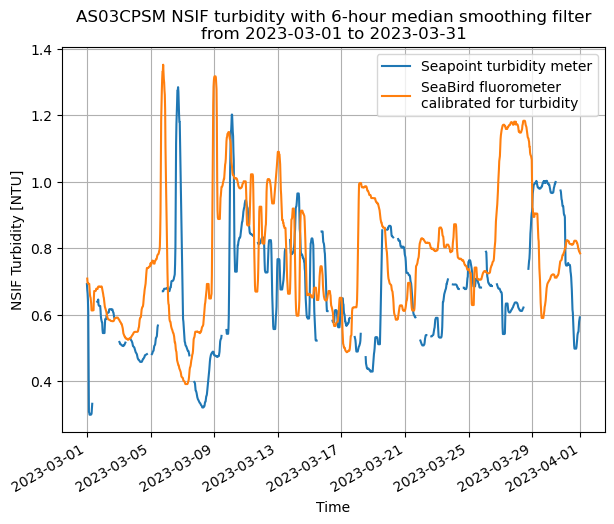

In [93]:
# Plot masked NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd1_mar.plot.line(ax=axs, label="Seapoint turbidity meter")
flort1_mar.plot.line(ax=axs, label="SeaBird fluorometer\ncalibrated for turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity with 6-hour median smoothing filter\nfrom {turbd1_mar["Time"][0].values:.10} to {turbd1_mar["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD1_FLORT1_Mar2023_6hrmedian_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

#### Download and parse flort2 recovered host files

In [37]:
url = "https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/"

In [38]:
# Set up file URL request with start and end dates from quick look cruise reports
files = get_file_urls(url, instr="flort2", start_date=20230224, end_date=20231026)
files

Finding logger files: 100%|██████████| 305/305 [00:00<00:00, 63876.90it/s]


['https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230224.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230225.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230226.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230227.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230228.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230301.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230302.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230303.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230304.flort2.log',
 

In [41]:
with ThreadPoolExecutor() as executor:
    executor.map(download_file, files)

Downloaded file 20230303.flort2.logDownloaded file 20230301.flort2.log

Downloaded file 20230226.flort2.log
Downloaded file 20230309.flort2.log
Downloaded file 20230307.flort2.log
Downloaded file 20230302.flort2.log
Downloaded file 20230306.flort2.log
Downloaded file 20230227.flort2.log
Downloaded file 20230313.flort2.log
Downloaded file 20230228.flort2.log
Downloaded file 20230320.flort2.log
Downloaded file 20230321.flort2.log
Downloaded file 20230324.flort2.log
Downloaded file 20230322.flort2.log
Downloaded file 20230323.flort2.log
Downloaded file 20230325.flort2.log
Downloaded file 20230326.flort2.log
Downloaded file 20230327.flort2.log
Downloaded file 20230328.flort2.log
Downloaded file 20230329.flort2.log
Downloaded file 20230318.flort2.log
Downloaded file 20230319.flort2.log
Downloaded file 20230224.flort2.log
Downloaded file 20230314.flort2.log
Downloaded file 20230311.flort2.log
Downloaded file 20230330.flort2.logDownloaded file 20230402.flort2.log

Downloaded file 20230310.flo

In [ ]:
# Use FLORT class imported from Parsers.parsers to load flort2 data from downloaded logger files
files = glob.glob("C:/Users/kylene.cooley/ast3_turbidity_data/*.flort2.log")
flort2 = FLORT()
flort2.load_flort(files)
flor_data = flort2.DATA
flor_data

In [44]:
# Convert backscatter to turbidity with FLORT bound method
# Scale factor and dark counts are from Secondary Characterizaton Sheet for FLORT-D SN1003
tu_flort2 = flort2.flort2turb(scale_factor=0.0300, dark_counts=50)
tu_flort2 = tu_flort2.rename({"TIMESTAMP": "time"}, axis=1)

In [45]:
# Convert Data Frame to Xarray Dataset
flort2_ntu = xr.Dataset.from_dataframe(tu_flort2.set_index("time"))
flort2_ntu

<xarray.Dataset>
Dimensions:           (time: 244578)
Coordinates:
  * time              (time) datetime64[ns] 2023-02-23T23:59:46 ... 2023-10-2...
Data variables:
    LGR_TIMESTAMP     (time) datetime64[ns] 2023-02-24T00:00:15.005000 ... 20...
    CH1               (time) object '700' '700' '700' ... '700' '700' '700'
    700NM_COUNTS      (time) int32 4130 4130 4130 4130 4130 ... 250 250 250 249
    CH2               (time) object '695' '695' '695' ... '695' '695' '695'
    695NM_COUNTS      (time) int32 1174 1172 1172 1171 1171 ... 48 46 46 46 46
    CH3               (time) object '460' '460' '460' ... '460' '460' '460'
    460NM_COUNTS      (time) int32 2128 2130 2133 2136 2134 ... 41 39 42 44 42
    THERM_COUNTS      (time) int32 549 549 549 549 549 ... 542 542 542 542 542
    backscatter_turb  (time) float64 122.4 122.4 122.4 122.4 ... 6.0 6.0 5.97

In [47]:
# Save Dataset to netCDF
savepath = os.path.abspath("C:/Users/kylene.cooley/ast3_turbidity_data/")
flort2_ntu.to_netcdf("/".join([savepath, "as03cpsm_dcl36_flort2.nc"]), mode="w")

#### Compare turbidity from SeaBird flort2 and Seapoint turbd on MFN

In [93]:
# Load flort2 from saved NetCDF file
flort2 = xr.load_dataset("C:/Users/kylene.cooley/ast3_turbidity_data/as03cpsm_dcl36_flort2.nc")
# Checking flort2 time delta while reassinging just the turbidity data array to name flort2_ntu
flort2_ntu = flort2["backscatter_turb"]
flort2_ntu

<xarray.DataArray 'backscatter_turb' (time: 244578)>
array([122.4 , 122.4 , 122.4 , ...,   6.  ,   6.  ,   5.97])
Coordinates:
  * time     (time) datetime64[ns] 2023-02-23T23:59:46 ... 2023-10-26T22:58:13

The turbidity meter on the MFN was not connected to the same dcl as the flort, so it is also recording a sample every 30 mins like the turbd on the NSIF.
The flort on the MFN only sampled at 1 Hz for 1 minute at the start of every hour.
I will be selecting just the turbidity meter sample from the first half of the hour.
I also need to apply a median to each burst of the flort on the MFN, so I will use the same method as before with a time freq of 1 hour.

In [94]:
# Index tubidity meter samples from the MFN taken at the top of the hour
turbd2_mfn = turbd2.sel(Time=(turbd2.Time.dt.minute==00), method="nearest")
turbd2_mfn

<xarray.DataArray 'Turbidity' (Time: 6074)>
array([0.04279942, 0.04327754, 0.04279942, ..., 0.04303848, 0.04351661,
       0.06646668])
Coordinates:
  * Time     (Time) datetime64[ns] 2023-02-22T17:00:01 ... 2023-11-02T18:00:01

In [95]:
# Resample flort2 turbidity to 1 sample per hour with median aggregation method
flort2_resample = flort2_ntu.resample(time="60min", origin="start").median()
flort2_resample

<xarray.DataArray 'backscatter_turb' (time: 5879)>
array([122.4 , 122.4 , 122.4 , ...,   3.81,   3.99,   6.03])
Coordinates:
  * time     (time) datetime64[ns] 2023-02-23T23:59:46 ... 2023-10-26T21:59:46

#### Plot MFN turbidity from flort2 and turbidity meter 

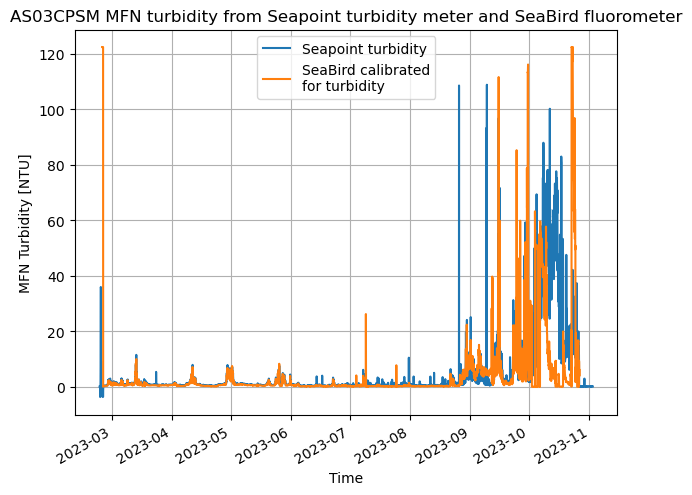

In [97]:
# Plot MFN Seapoint turbidity (not smoothed) with turbidity from flort2 backscatter after burst median
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd2_mfn.plot.line(ax=axs, label="Seapoint turbidity")
flort2_resample.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('MFN Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM MFN turbidity from Seapoint turbidity meter and SeaBird fluorometer')
plt.savefig('figures/AS03CPSM_TURBD2_FLORT2_full_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [98]:
# Recreate plot for July 2023 with NSIF data from both sensors
# Select Seapoint turbidity measured in July 2023
turbd2_jul = turbd2_mfn.sel(Time="July 2023")
flort2_jul = flort2_resample.sel(time="July 2023")

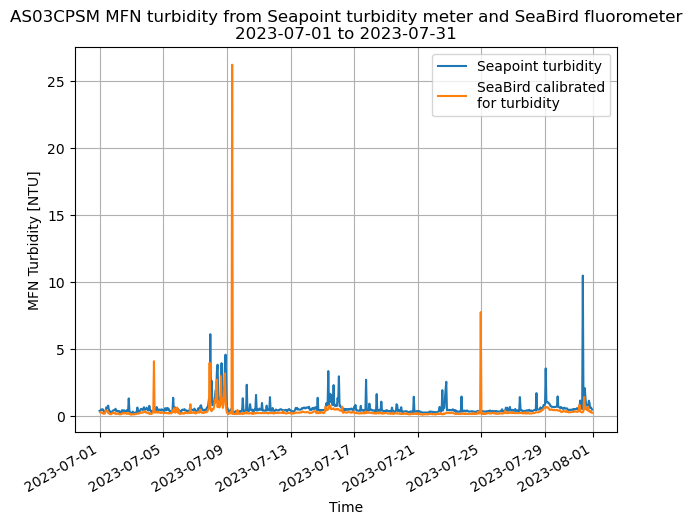

In [99]:
# Plot masked NSIF turbidity from Seapoint meter and FLORT-derived turbidity (burst median)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd2_jul.plot.line(ax=axs, label="Seapoint turbidity")
flort2_jul.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('MFN Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM MFN turbidity from Seapoint turbidity meter and SeaBird fluorometer\n{turbd2_jul["Time"][0].values:.10} to {turbd2_jul["Time"][-1].values:.10}')
plt.savefig('figures/AS03CPSM_TURBD2_FLORT2_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [101]:
# Create time series variables for May 2023
turbd2_may = turbd2_mfn.sel(Time="May 2023")
flort2_may = flort2_resample.sel(time="May 2023")

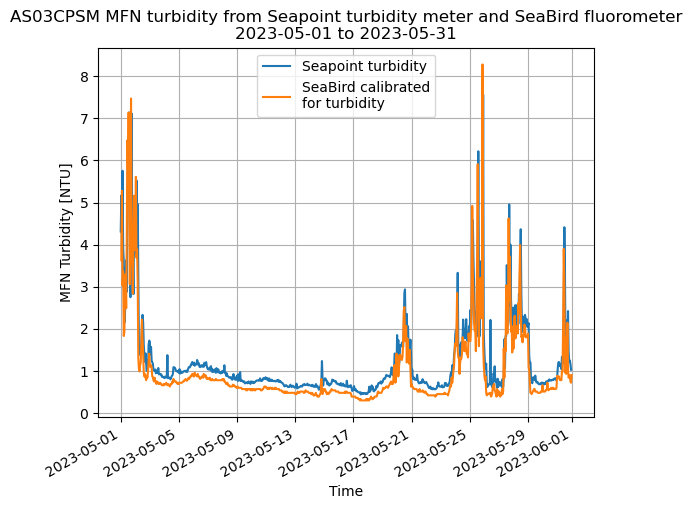

In [102]:
# Plot close-up of May 2023 with both TURBD2 and FLORT2 (burst median)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True)
turbd2_may.plot.line(ax=axs, label="Seapoint turbidity")
flort2_may.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('MFN Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM MFN turbidity from Seapoint turbidity meter and SeaBird fluorometer\n{turbd2_may["Time"][0].values:.10} to {turbd2_may["Time"][-1].values:.10}')
plt.savefig('figures/AS03CPSM_TURBD2_FLORT2_May2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [103]:
# Create time series variables for March 2023
turbd2_mar = turbd2_mfn.sel(Time="March 2023")
flort2_mar = flort2_resample.sel(time="March 2023")

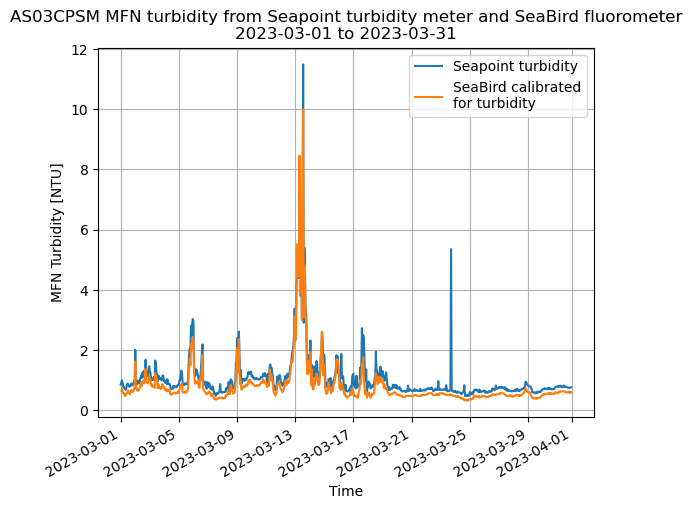

In [104]:
# Plot close-up of March 2023 with both TURBD2 and FLORT2 (burst median)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True)
turbd2_mar.plot.line(ax=axs, label="Seapoint turbidity")
flort2_mar.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('MFN Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM MFN turbidity from Seapoint turbidity meter and SeaBird fluorometer\n{turbd2_mar["Time"][0].values:.10} to {turbd2_mar["Time"][-1].values:.10}')
plt.savefig('figures/AS03CPSM_TURBD2_FLORT2_Mar2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [105]:
# Given the apparent agreement between MFN turbidity options I want to get a closer look at Oct 2023
# when the signals are quite different.
turbd2_oct = turbd2_mfn.sel(Time="October 2023")
flort2_oct = flort2_resample.sel(time="October 2023")

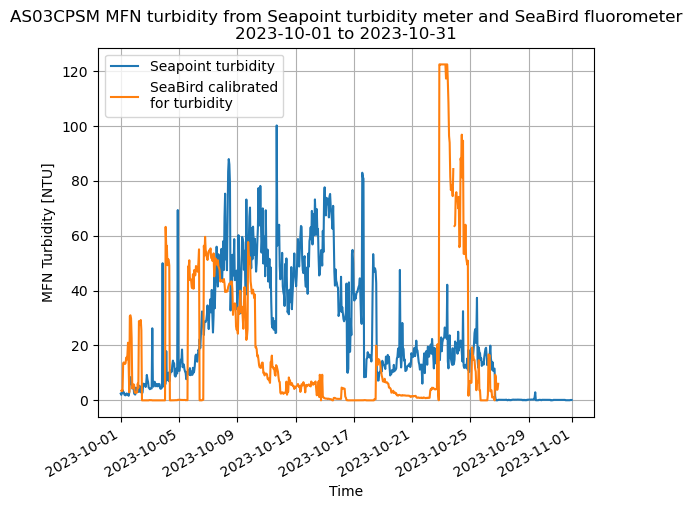

In [106]:
# Plot close-up of Oct 2023 with both TURBD2 and FLORT2 (burst median)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True)
turbd2_oct.plot.line(ax=axs, label="Seapoint turbidity")
flort2_oct.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('MFN Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM MFN turbidity from Seapoint turbidity meter and SeaBird fluorometer\n{turbd2_oct["Time"][0].values:.10} to {turbd2_oct["Time"][-1].values:.10}')
plt.savefig('figures/AS03CPSM_TURBD2_FLORT2_Oct2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

#### Check MFN turbidity signals for constant offset

In [141]:
# Use MFN Seapoint turbidity and arbitrary threshold of 2 NTU to index individual "events"
# and limit to turbidity measurements under 20 NTU (uncharacteristic of area?)
# We will exclude from Sept 2023 onwards, since the figure above shows how one of the sensors (likely SeaBird) is not measuring the water accurately
# Also starting data from start of March since there appears to be some outliers at the start, and I'm not sure if this was before it was actually in the water
turbd2_events = turbd2_mfn.where(turbd2_mfn>2, drop=True).where(turbd2_mfn<20, drop=True).sel(Time=slice("2023-03-01", "2023-09-01"))
flort2_events = flort2_resample.sel(time=(turbd2_events["Time"].values), method="nearest")

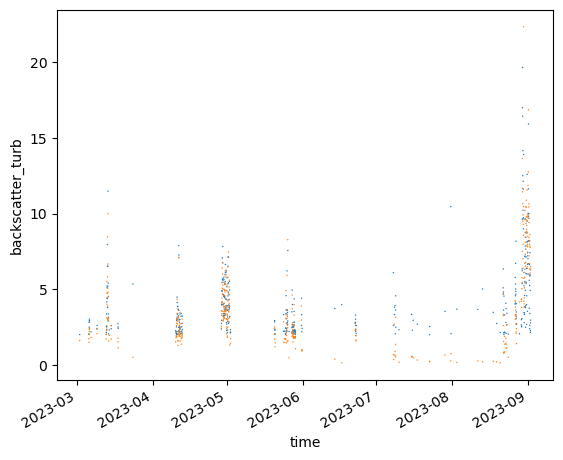

In [142]:
# Scatter of these points as a function of time to check indexing
fig, ax = plt.subplots(1, 1)
turbd2_events.plot.scatter(ax=ax, edgecolors="none", s=1)
flort2_events.plot.scatter(ax=ax, edgecolors="none", s=1)

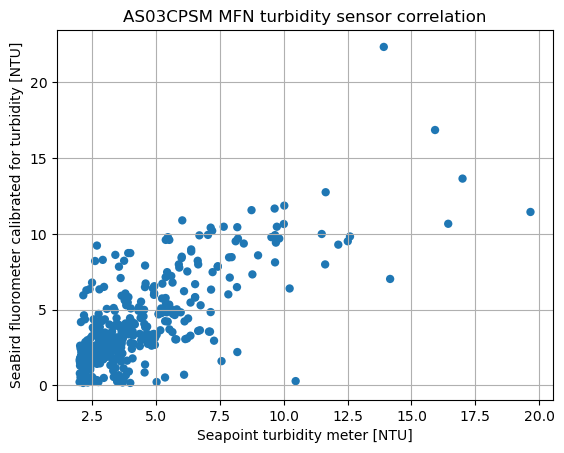

In [145]:
# Scatter of FLORT as a function of TURBD
fig, ax = plt.subplots(1, 1)
plt.scatter(turbd2_events.values, flort2_events.values, edgecolors="none")
plt.grid()
ax.set_xlabel("Seapoint turbidity meter [NTU]")
ax.set_ylabel("SeaBird fluorometer calibrated for turbidity [NTU]")
plt.title("AS03CPSM MFN turbidity sensor correlation")
plt.show()

In [149]:
# Expand dimensions of data arrays by 1 so that we can use the scikit-learn LinearRegression object
turbd2_expand = turbd2_events.expand_dims("feature", axis=1)
flort2_expand = flort2_events.expand_dims("feature", axis=1)

In [151]:
# Do a linear regression on these points to estimate a constant offset for this period
mfn_reg = LinearRegression().fit(turbd2_expand, flort2_expand)
mfn_reg.coef_

array([[0.85770309]])

In [152]:
mfn_reg.intercept_

array([0.31675638])

In [153]:
# Check R-squared score of fit
mfn_reg.score(turbd2_expand, flort2_expand)

0.5562614691000881

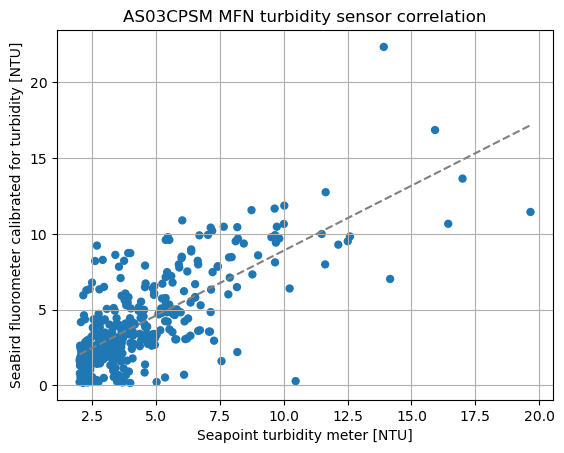

In [169]:
# Create new scatter plot with linear regression line
x = np.linspace(turbd2_events.min().values, turbd2_events.max().values)
y = np.squeeze(mfn_reg.intercept_[0] + mfn_reg.coef_[[0]]*x)

fig, ax = plt.subplots(1, 1)
plt.scatter(turbd2_events.values, flort2_events.values, edgecolors="none")
plt.plot(x, y, '--', color="gray")
plt.grid()
ax.set_xlabel("Seapoint turbidity meter [NTU]")
ax.set_ylabel("SeaBird fluorometer calibrated for turbidity [NTU]")
plt.title("AS03CPSM MFN turbidity sensor correlation")
plt.show()

In [170]:
# Create a simple function to make the same plot as above with a linear regression line to reuse
def scatter_linreg(a, b, title):
    """Make a scatter plot of two data arrays a and b with b as a function of a.
    Then use scikit-learn LinearRegression object to evaluate the ordinary least
    squares fit to the data, and overlay the fit as a dashed gray line over the scatter plot.
    """ 
    # Expand dimensions of data arrays by 1 so that we can use the scikit-learn LinearRegression object
    a_expand = a.expand_dims("feature", axis=1)
    b_expand = b.expand_dims("feature", axis=1)

    # Do a linear regression on these points to estimate a constant offset for this period
    reg = LinearRegression().fit(a_expand, b_expand)
    
    # Use LinearRegression results to create vectors for the plot
    x = np.linspace(a.min().values, a.max().values)
    y = np.squeeze(reg.intercept_[0] + reg.coef_[[0]]*x)

    # Scatter plot with linear regression line
    fig, ax = plt.subplots(1, 1)
    plt.scatter(a.values, b.values, edgecolors="none")
    plt.plot(x, y, '--', color="gray")
    plt.grid()
    ax.set_xlabel("Seapoint turbidity meter [NTU]")
    ax.set_ylabel("SeaBird fluorometer calibrated for turbidity [NTU]")
    plt.title(title)
    plt.show()

    return fig, ax

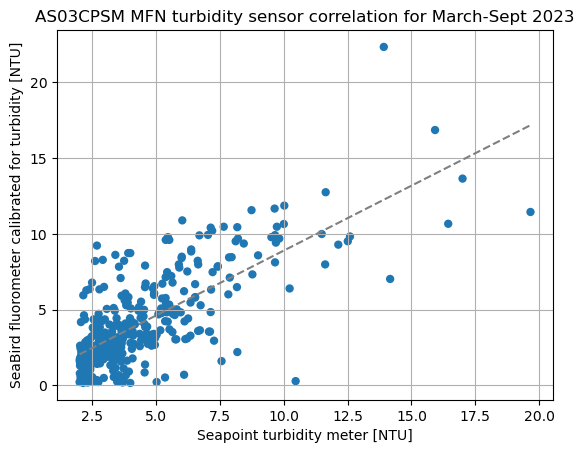

In [172]:
# Try out the new function
fig, ax = scatter_linreg(turbd2_events, flort2_events, "AS03CPSM MFN turbidity sensor correlation for March-Sept 2023")

#### Check NSIF turbidity for time lag of Seapoint turbidity meter to FLORT turbidity

### Compare both sensor measurements with cruise data from CTD casts

In [63]:
# Import cast 002 data
cast2_file = "C:/Users/kylene.cooley/ast3_turbidity_data/ar71-04_002.asc"
cast2_data = pd.read_csv(cast2_file, sep="\s+", header=None, usecols=[0, 2, 11, 12, 13, 14], encoding="ascii", encoding_errors="replace")
cast2_data 

,0,2,11,12,13,14
0,TimeQ,DepSM,FlECO-AFL,CStarTr0,CStarAt0TurbWETntu0,Par
1,730566887,3.971,0.2413,92.5014,0.3118,0.2347
2,730566910,4.963,0.2234,92.5014,0.3118,0.2374
3,730566913,5.956,0.2529,92.4702,0.3131,0.2455
4,730566915,6.949,0.2725,92.3654,0.3177,0.2553
5,730566917,7.941,0.2974,92.2448,0.3229,0.2616
6,730566919,8.934,0.3255,92.2195,0.3240,0.2497
7,730566920,9.927,0.3875,92.1601,0.3266,0.2516
8,730566922,10.919,0.4679,92.0951,0.3294,0.2575
9,730566924,11.912,0.5647,92.0265,0.3324,0.2757


In [64]:
# We need to drop the first row, add the correct column names, convert time to an actual value, and set time as the index
cast2_data = cast2_data.drop(index=0, axis=0)
cast2_data.rename(columns={0: "time", 2: "depth", 11: "fluorescence", 12: "beam transmission", 13: "beam attenuation", 14: "turbidity"}, inplace=True)

In [69]:
# Convert "time" to a datetime object and set as index
cast2_data.set_index(pd.to_datetime(cast2_data.time.astype(float), utc=True, unit="s", origin="2000-01-01T00:00:00"), inplace=True)
cast2_data.drop("time", axis=1, inplace=True)
# cast2_data

,depth,fluorescence,beam transmission,beam attenuation,turbidity
time,,,,,
2023-02-24 15:14:47+00:00,3.971,0.2413,92.5014,0.3118,0.2347
2023-02-24 15:15:10+00:00,4.963,0.2234,92.5014,0.3118,0.2374
2023-02-24 15:15:13+00:00,5.956,0.2529,92.4702,0.3131,0.2455
2023-02-24 15:15:15+00:00,6.949,0.2725,92.3654,0.3177,0.2553
2023-02-24 15:15:17+00:00,7.941,0.2974,92.2448,0.3229,0.2616
2023-02-24 15:15:19+00:00,8.934,0.3255,92.2195,0.3240,0.2497
2023-02-24 15:15:20+00:00,9.927,0.3875,92.1601,0.3266,0.2516
2023-02-24 15:15:22+00:00,10.919,0.4679,92.0951,0.3294,0.2575
2023-02-24 15:15:24+00:00,11.912,0.5647,92.0265,0.3324,0.2757


In [85]:
# Convert data frame to an xarray dataset
cast2 = xr.Dataset(cast2_data)
cast2 = cast2.astype(float)
cast2 = cast2.assign_coords({"time": cast2_data.index.values})
cast2

<xarray.Dataset>
Dimensions:            (time: 56)
Coordinates:
  * time               (time) datetime64[ns] 2023-02-24T15:14:47 ... 2023-02-...
Data variables:
    depth              (time) float64 3.971 4.963 5.956 ... 4.963 3.971 2.978
    fluorescence       (time) float64 0.2413 0.2234 0.2529 ... 0.3014 0.3682
    beam transmission  (time) float64 92.5 92.5 92.47 ... 92.26 92.23 92.37
    beam attenuation   (time) float64 0.3118 0.3118 0.3131 ... 0.3236 0.3175
    turbidity          (time) float64 0.2347 0.2374 0.2455 ... 0.2391 0.2432

In [107]:
# Add scatter points of turbidity over short timeseries from NSIF
turbd1_cruise = turbd1.sel(Time=slice("2023-02-24T14:00:00", "2023-02-24T16:30:00"))
flort1_cruise = flort1_resample.sel(time=slice("2023-02-24T14:00:00", "2023-02-24T16:30:00"))

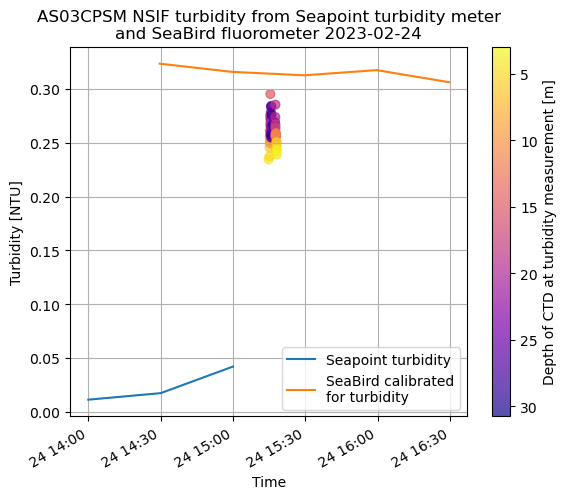

In [135]:
# Plot close-up of March 2023 with both TURBD1 and FLORT1 (burst median)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True)
turbd1_cruise.plot.line(ax=axs, label="Seapoint turbidity")
flort1_cruise.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
cast_scatt = plt.scatter(cast2["time"], cast2["turbidity"], c=cast2["depth"], cmap=cm._colormaps["plasma_r"], edgecolors="face", s=40, alpha=0.7)
axs.grid()
axs.set_ylabel('Turbidity [NTU]')
axs.set_xlabel('Time')
cbar = plt.colorbar(label="Depth of CTD at turbidity measurement [m]")
cbar.ax.invert_yaxis()
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity from Seapoint turbidity meter\nand SeaBird fluorometer {turbd1_cruise["Time"][0].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD1_FLORT1_Mar2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [129]:
# Add scatter points of turbidity over short timeseries from MFN
turbd2_cruise = turbd2_mfn.sel(Time=slice("2023-02-24T14:00:00", "2023-02-24T16:30:00"))
flort2_cruise = flort2_resample.sel(time=slice("2023-02-24T14:00:00", "2023-02-24T16:30:00"))

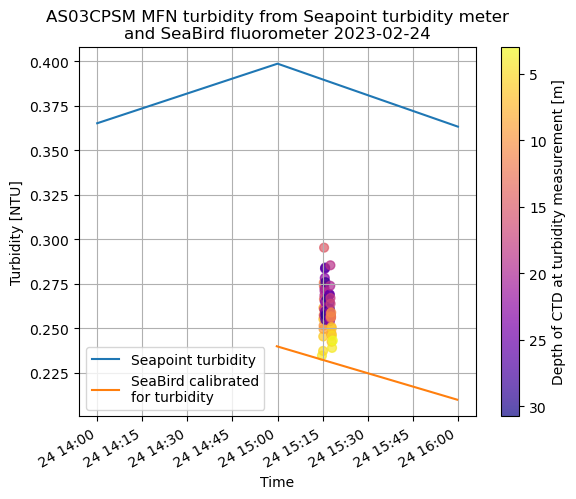

In [134]:
# Plot close-up of March 2023 with both TURBD1 and FLORT1 (burst median)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True)
turbd2_cruise.plot.line(ax=axs, label="Seapoint turbidity")
flort2_cruise.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
cast_scatt = plt.scatter(cast2["time"], cast2["turbidity"], c=cast2["depth"], cmap=cm._colormaps["plasma_r"], edgecolors="face", s=40, alpha=0.7)
axs.grid()
axs.set_ylabel('Turbidity [NTU]')
axs.set_xlabel('Time')
cbar = plt.colorbar(label="Depth of CTD at turbidity measurement [m]")
cbar.ax.invert_yaxis()
plt.legend()
axs.set_title(f'AS03CPSM MFN turbidity from Seapoint turbidity meter\nand SeaBird fluorometer {turbd2_cruise["Time"][0].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD1_FLORT1_Mar2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()